#  Problem Statement 1:

 A retail store that has multiple outlets across the country are facing issues in managing the
 inventory - to match the demand with respect to supply.
 
 
 Dataset Information:
 
 The walmart.csv contains 6435 rows and 8 columns.
 
 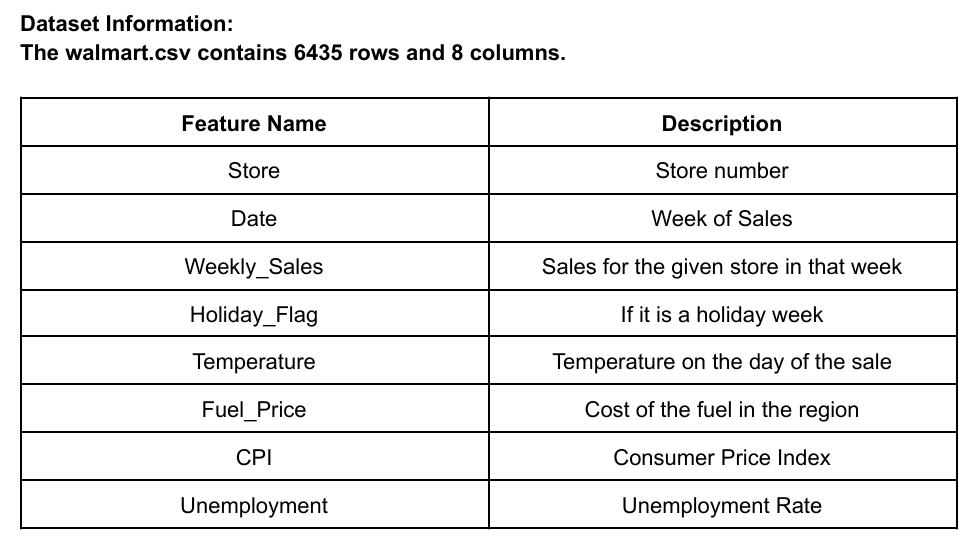
 
 
 1. You are provided with the weekly sales data for their various outlets. Use statistical  analysis, EDA, outlier analysis, and handle the missing values to come up with various  insights that can give them a clear perspective on the following:
 
 a. If the weekly sales are affected by the unemployment rate, if yes - which stores are suffering the most?
 
 b. If the weekly sales show a seasonal trend, when and what could be the reason?
 
 c. Does temperature affect the weekly sales in any manner?
 
 d. How is the Consumer Price index affecting the weekly sales of various stores?
 
 e. Top performing stores according to the historical data.
 
 f. The worst performing store, and how significant is the difference between the highest and lowest performing stores.
 
 2. Use predictive modeling techniques to forecast the sales for each store for the next 12 weeks

### 1. Load Important Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import streamlit as st
from ipywidgets import interact, widgets
import statsmodels.api as sm
import ipywidgets as widgets
from IPython.display import display
from prophet import Prophet

import argparse, os, warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

### 2. Set Working Directory

In [2]:
os.chdir(r"C:\Users\raman\Downloads\Intellipat Capston Project - Walmart")

### 3. Load The Data

In [3]:
df = pd.read_csv("WalmartDataSet.csv")
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


### 4. Data Exploration

In [4]:
df.shape

(6435, 8)

In [5]:
df.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [7]:
# Convert 'Date' to datetime

df['Date'] = pd.to_datetime(df['Date'], format="%d-%m-%Y")

# Extract Month year and week
df['Month'] = df['Date'].dt.month
df["Year"] = df["Date"].dt.isocalendar().year
df["Week"] = df["Date"].dt.isocalendar().week


# Combine Year + Week (for grouping)
df["Year_Week"] = df["Year"].astype(str) + "-W" + df["Week"].astype(str)

# Combine Year + Month (for grouping)
df["Year_Month"] = df["Year"].astype(str) + "-M" + df["Month"].astype(str)


# Extract month and year
#df['month'] = df['Date'].dt.month
#df['year'] = df['Date'].dt.year
#df["Week_Number"] = df["Date"].dt.isocalendar().week
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Month,Year,Week,Year_Week,Year_Month
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,2,2010,5,2010-W5,2010-M2
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,2,2010,6,2010-W6,2010-M2
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,2,2010,7,2010-W7,2010-M2
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,2,2010,8,2010-W8,2010-M2
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,3,2010,9,2010-W9,2010-M3


### 5. Missing Value Analysis

In [8]:
missing_val = df.isna().sum()
missing_val_Percent = (missing_val/len(df))*100
missing_val_analysis = {'missing_val': missing_val , 'missing_val_percentage': missing_val_Percent}
missing_val_analysis = pd.DataFrame(missing_val_analysis)
missing_val_analysis

,missing_val,missing_val_percentage
Store,0,0.0
Date,0,0.0
Weekly_Sales,0,0.0
Holiday_Flag,0,0.0
Temperature,0,0.0
Fuel_Price,0,0.0
CPI,0,0.0
Unemployment,0,0.0
Month,0,0.0
Year,0,0.0


There is No Missing Values in the Data

### 6. Outlier Analysis 

In [9]:
# Define outlier detection function
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) | (data[column] <= upper_bound)]

# Interactive dashboard
@interact(
    store=widgets.Dropdown(options=sorted(df['Store'].unique()), description='Store'),
    holiday=widgets.Checkbox(value=False, description='Holiday Weeks Only'),
    promo=widgets.Checkbox(value=False, description='Promotional Weeks Only')
)
def plot_outliers(store, holiday, promo):
    # Filter by store
    data = df[df['Store'] == store]

    # Apply holiday filter
    if holiday and 'Holiday_Flag' in data.columns:
        data = data[data['Holiday_Flag'] == 1]

    # Apply promo filter (if you have a 'Promotion' column)
    if promo and 'Promotion' in data.columns:
        data = data[data['Promotion'] == True]

    # Columns to analyze
    numeric_cols = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']

    for col in numeric_cols:
        outliers = detect_outliers_iqr(data, col)
        plt.figure(figsize=(10, 4))
        sns.boxplot(x=data[col])
        plt.title(f'{col} Outliers for Store {store} {"(Holiday)" if holiday else ""} {"(Promo)" if promo else ""}')
        plt.show()

        print(f"{col}: {len(outliers)} outliers detected")

interactive(children=(Dropdown(description='Store', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15…

# Problem Statements :

## 1.  Various insights that can give them a clear perspective on the following 

###  a.If the weekly sales are affected by the unemployment rate, if yes - which stores are suffering the most?

📌 Store-wise unemployment impact on weekly sales (Significant only, p < 0.05):

    Store  Unemployment_Coeff       p_value
40     41      -166181.375633  1.760959e-05
38     39      -119050.372488  2.099708e-06
16     17       -90832.279462  1.467766e-03
3       4       -63122.487555  3.858223e-05
12     13       -51695.600480  4.039835e-02
6       7       -43356.170450  4.838919e-02
8       9       -28550.729251  2.193021e-02
37     38       -27799.885317  3.721186e-31
2       3       -23863.097246  5.631340e-03
41     42       -21230.027486  1.252380e-05


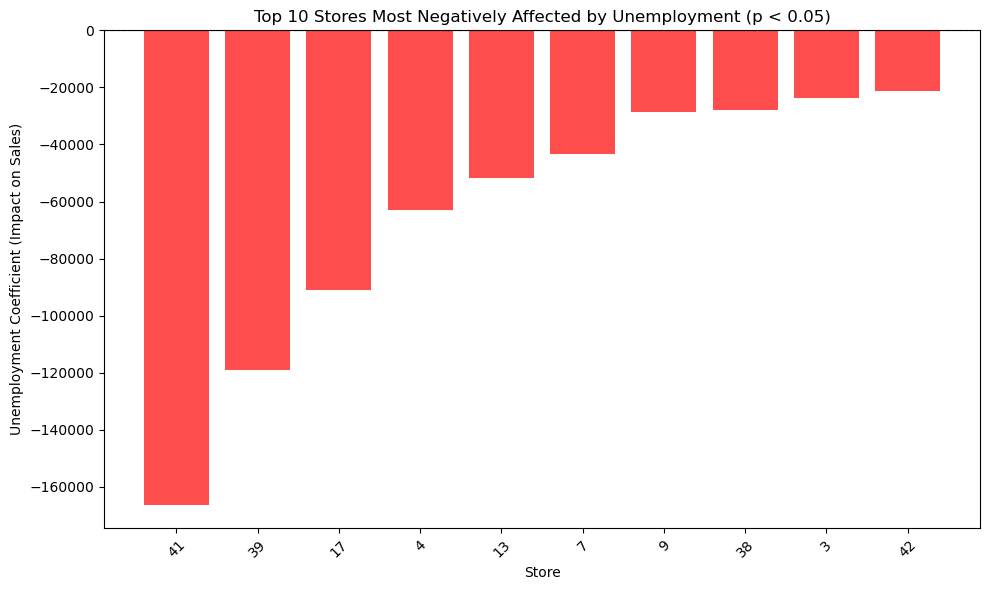

In [10]:
# Store-wise regression: Weekly_Sales ~ Unemployment
results = []
for store, group in df.groupby("Store"):
    X = sm.add_constant(group["Unemployment"])   # independent var
    y = group["Weekly_Sales"]                    # dependent var
    model = sm.OLS(y, X).fit()
    coef = model.params["Unemployment"]
    pval = model.pvalues["Unemployment"]
    results.append((store, coef, pval))

# Create results dataframe
reg_results = pd.DataFrame(results, columns=["Store", "Unemployment_Coeff", "p_value"])

# Filter only significant results (p < 0.05)
significant_results = reg_results[reg_results["p_value"] < 0.05]

# Sort by coefficient (most negative = most affected)
significant_results_sorted = significant_results.sort_values("Unemployment_Coeff")

print("📌 Store-wise unemployment impact on weekly sales (Significant only, p < 0.05):\n")
print(significant_results_sorted.head(10))   # Top 10 most affected stores

# --- Visualization ---
top10 = significant_results_sorted.head(10)

plt.figure(figsize=(10,6))
plt.bar(top10["Store"].astype(str), top10["Unemployment_Coeff"], color="red", alpha=0.7)
plt.axhline(0, color="black", linewidth=0.8, linestyle="--")
plt.title("Top 10 Stores Most Negatively Affected by Unemployment (p < 0.05)")
plt.xlabel("Store")
plt.ylabel("Unemployment Coefficient (Impact on Sales)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### b. If the weekly sales show a seasonal trend, when and what could be the reason? 

In [11]:
# Define the analysis function
def analyze_store(store_id):
    # Filter data for the selected store
    store_df = df[df['Store'] == store_id].copy()
    
    print(f"\n📊 Analysis for Store {store_id}\n")
    
    
    # Sort by Date
    store_df = store_df.sort_values("Date")
    
    # Line chart: Weekly Sales vs Year_Week
    plt.figure(figsize=(14,6))
    plt.plot(store_df['Date'], store_df['Weekly_Sales'], marker='o', color='blue')
    plt.title(f"Store {store_id} - Weekly Sales by Year_Week")
    plt.ylabel('Weekly Sales')
    plt.xlabel('Year-Week')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
# Create dropdown widget for store selection
store_ids = sorted(df['Store'].unique())
interact(analyze_store, store_id=widgets.Dropdown(options=store_ids, description='Select Store:'))

interactive(children=(Dropdown(description='Select Store:', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13…

<function __main__.analyze_store(store_id)>

In [12]:
# Function for seasonal decomposition per store
def analyze_store_decomposition(store_id):
    store_df = df[df['Store'] == store_id].copy()
    
    # Time series with Date as index
    ts = store_df.set_index("Date")["Weekly_Sales"].sort_index()

    # Ensure continuous weekly index
    full_index = pd.date_range(start=ts.index.min(), end=ts.index.max(), freq='W-FRI')
    ts = ts.reindex(full_index)

    # Fill missing values
    ts = ts.interpolate(method='linear')

    # Only decompose if we have at least 52 weeks
    if len(ts) > 52:
        result = seasonal_decompose(ts, model="additive", period= 12)
        
        # Plot results
        fig = result.plot()
        fig.set_size_inches(12, 8)
        plt.suptitle(f"Store {store_id} - Seasonal Decomposition of Weekly Sales", fontsize=16, y=1.02)
        plt.show()
    else:
        print(f"⚠️ Not enough data for Store {store_id} to perform seasonal decomposition.")

# Dropdown widget for store selection
store_ids = sorted(df['Store'].unique())
interact(analyze_store_decomposition, store_id=widgets.Dropdown(options=store_ids, description="Select Store:"))

interactive(children=(Dropdown(description='Select Store:', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13…

<function __main__.analyze_store_decomposition(store_id)>

We see there is seasonal trend. At the time of New Year there is a spike.

### c. Does temperature affect the weekly sales in any manner? 


📊 CPI vs Weekly Sales Correlation by Store

    Store  Temp_Correlation
0       1         -0.222701
1       2         -0.297673
2       3         -0.377524
3       4         -0.225583
4       5         -0.175517
5       6         -0.084863
6       7          0.015077
7       8         -0.312324
8       9         -0.208343
9      10         -0.432569
10     11         -0.278503
11     12         -0.379416
12     13         -0.137746
13     14         -0.199851
14     15         -0.050541
15     16          0.182948
16     17          0.081012
17     18         -0.144278
18     19         -0.080805
19     20         -0.264983
20     21         -0.177084
21     22         -0.082892
22     23          0.056257
23     24          0.111833
24     25         -0.031311
25     26          0.211722
26     27          0.121809
27     28         -0.376506
28     29         -0.129144
29     30         -0.330816
30     31         -0.262192
31     32         -0.111681
32     33          0.019244
33 

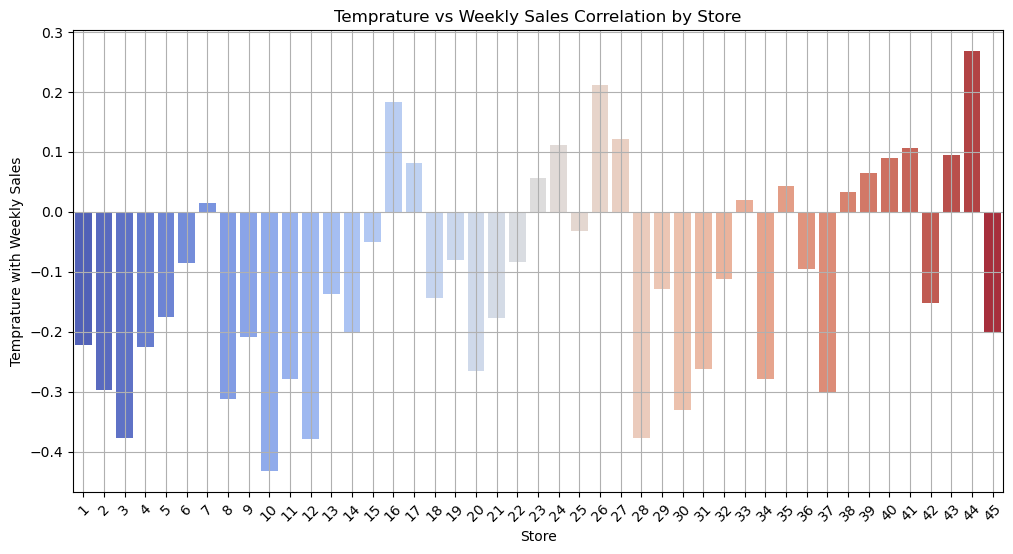

In [13]:
# Correlation summary for all stores
cpi_corr_summary = df.groupby('Store').apply(lambda x: x['Temperature'].corr(x['Weekly_Sales'])).reset_index()
cpi_corr_summary.columns = ['Store', 'Temp_Correlation']

print("\n📊 CPI vs Weekly Sales Correlation by Store\n")
print(cpi_corr_summary)

# Plot bar chart
plt.figure(figsize=(12,6))
sns.barplot(data=cpi_corr_summary, x='Store', y='Temp_Correlation', palette='coolwarm')
plt.title("Temprature vs Weekly Sales Correlation by Store")
plt.xlabel("Store")
plt.ylabel("Temprature with Weekly Sales")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Higher the Temprature = Lower The Weekly Sale

### d. How is the Consumer Price index affecting the weekly sales of various stores? 


📊 CPI vs Weekly Sales Correlation by Store

    Store  CPI_Correlation
0       1         0.225408
1       2        -0.062431
2       3         0.317250
3       4         0.351157
4       5         0.308261
5       6        -0.011357
6       7         0.289044
7       8         0.120255
8       9         0.294805
9      10        -0.115374
10     11         0.069781
11     12         0.084087
12     13         0.163976
13     14        -0.419755
14     15        -0.174467
15     16         0.124285
16     17         0.348571
17     18        -0.193541
18     19        -0.155341
19     20         0.058706
20     21        -0.163649
21     22        -0.038602
22     23         0.084248
23     24        -0.013684
24     25        -0.010914
25     26         0.131980
26     27        -0.213082
27     28        -0.095908
28     29        -0.072530
29     30        -0.298188
30     31         0.132887
31     32         0.196782
32     33        -0.052271
33     34         0.115437
34     35 

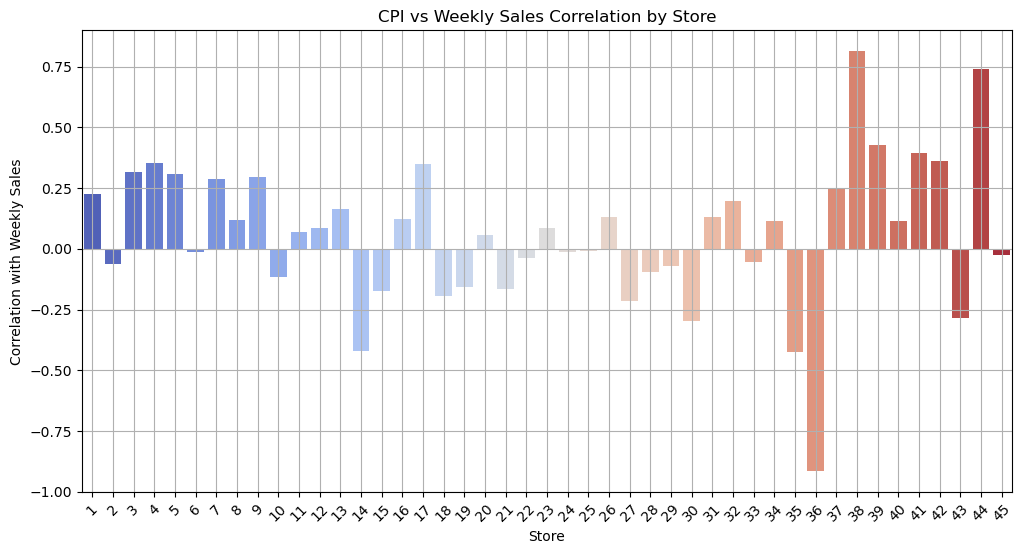

In [14]:
# Correlation summary for all stores
cpi_corr_summary = df.groupby('Store').apply(lambda x: x['CPI'].corr(x['Weekly_Sales'])).reset_index()
cpi_corr_summary.columns = ['Store', 'CPI_Correlation']

print("\n📊 CPI vs Weekly Sales Correlation by Store\n")
print(cpi_corr_summary)

# Plot bar chart
plt.figure(figsize=(12,6))
sns.barplot(data=cpi_corr_summary, x='Store', y='CPI_Correlation', palette='coolwarm')
plt.title("CPI vs Weekly Sales Correlation by Store")
plt.xlabel("Store")
plt.ylabel("Correlation with Weekly Sales")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

CPI affects stores differently — there is no uniform impact across all stores

Different Stores shows Different Trends against CPI

Stores 1–15 approx : Mostly low to moderate positive correlations (0.1 to 0.35). In these stores, higher CPI (inflation) didn’t reduce sales much

Stores 16-35 approx : Several negative correlations. For these stores, as CPI rose, sales dropped sharply

Stores 36-45 : A mix of very strong positive correlations and some negative ones. 

### e. Top performing stores according to the historical data. 

🏆 Top Stores by Total Sales : 
    Store   Total_Sales  Avg_Weekly_Sales  Sales_Variability
19     20  3.013978e+08      2.107677e+06      275900.562742
3       4  2.995440e+08      2.094713e+06      266201.442297
13     14  2.889999e+08      2.020978e+06      317569.949476
12     13  2.865177e+08      2.003620e+06      265506.995776
1       2  2.753824e+08      1.925751e+06      237683.694682
9      10  2.716177e+08      1.899425e+06      302262.062504
26     27  2.538559e+08      1.775216e+06      239930.135688
5       6  2.237561e+08      1.564728e+06      212525.855862
0       1  2.224028e+08      1.555264e+06      155980.767761
38     39  2.074455e+08      1.450668e+06      217466.454833


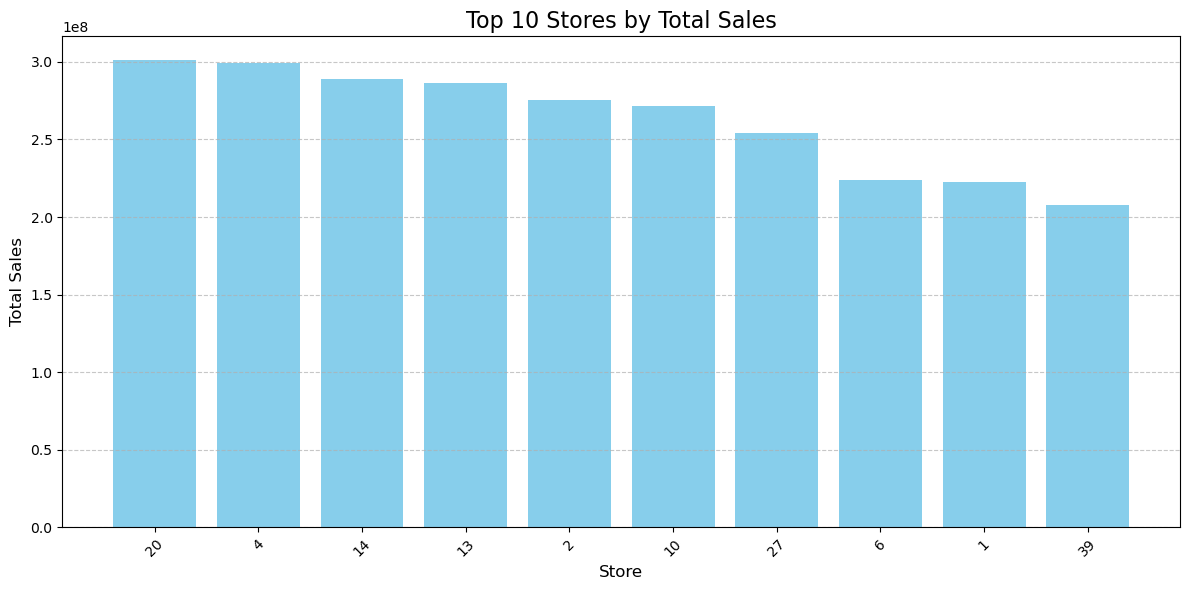


🏆 Top Stores by Average Weekly Sales : 
    Store   Total_Sales  Avg_Weekly_Sales  Sales_Variability
19     20  3.013978e+08      2.107677e+06      275900.562742
3       4  2.995440e+08      2.094713e+06      266201.442297
13     14  2.889999e+08      2.020978e+06      317569.949476
12     13  2.865177e+08      2.003620e+06      265506.995776
1       2  2.753824e+08      1.925751e+06      237683.694682
9      10  2.716177e+08      1.899425e+06      302262.062504
26     27  2.538559e+08      1.775216e+06      239930.135688
5       6  2.237561e+08      1.564728e+06      212525.855862
0       1  2.224028e+08      1.555264e+06      155980.767761
38     39  2.074455e+08      1.450668e+06      217466.454833


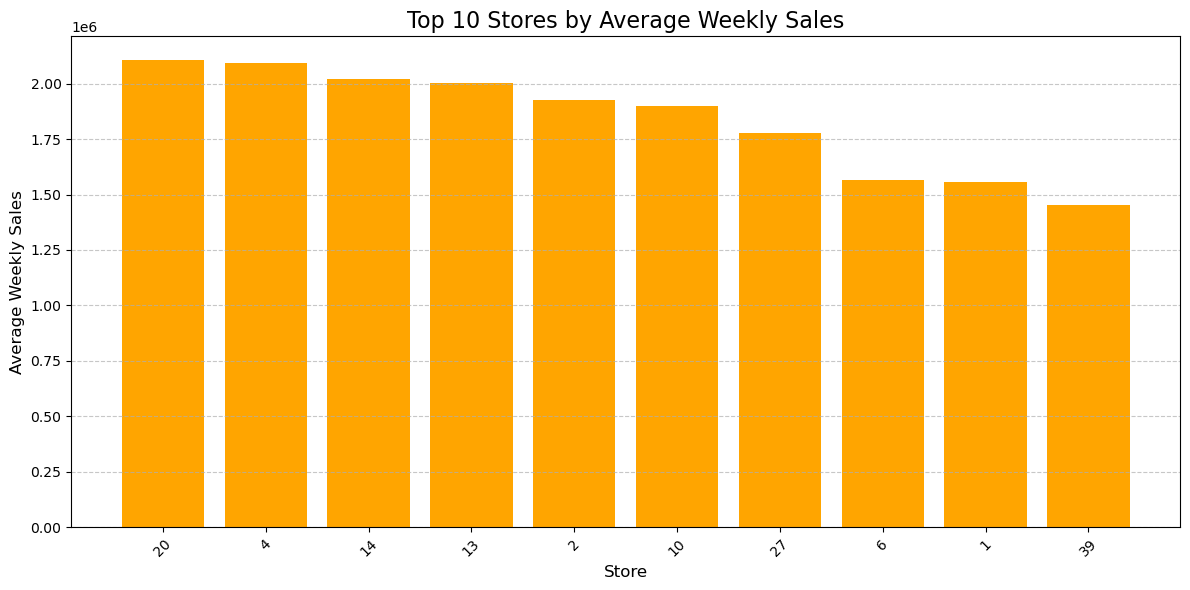

In [15]:
# Aggregate store-level performance
store_performance = df.groupby('Store')['Weekly_Sales'].agg(
    Total_Sales='sum',
    Avg_Weekly_Sales='mean',
    Sales_Variability='std'
).reset_index()

# Top 10 by Total Sales
top_total = store_performance.sort_values(by='Total_Sales', ascending=False).head(10)

# Top 10 by Average Weekly Sales
top_avg = store_performance.sort_values(by='Avg_Weekly_Sales', ascending=False).head(10)

print("🏆 Top Stores by Total Sales : ")
print(top_total)

#Plot Top 10 by Total Sales
plt.figure(figsize=(12,6))
plt.bar(top_total['Store'].astype(str), top_total['Total_Sales'], color='skyblue')
plt.title("Top 10 Stores by Total Sales", fontsize=16)
plt.xlabel("Store", fontsize=12)
plt.ylabel("Total Sales", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



print("\n🏆 Top Stores by Average Weekly Sales : ")
print(top_avg)

#Plot Top 10 by Average Weekly Sales
plt.figure(figsize=(12,6))
plt.bar(top_avg['Store'].astype(str), top_avg['Avg_Weekly_Sales'], color='orange')
plt.title("Top 10 Stores by Average Weekly Sales", fontsize=16)
plt.xlabel("Store", fontsize=12)
plt.ylabel("Average Weekly Sales", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### f. The worst performing store, and how significant is the difference between the highest and lowest performing stores. 

🏆 Best Performing Store:
Store                2.000000e+01
Total_Sales          3.013978e+08
Avg_Weekly_Sales     2.107677e+06
Sales_Variability    2.759006e+05
Name: 19, dtype: float64

❌ Worst Performing Store:
Store                3.300000e+01
Total_Sales          3.716022e+07
Avg_Weekly_Sales     2.598617e+05
Sales_Variability    2.413293e+04
Name: 32, dtype: float64

🔎 Difference in Total Sales: 264,237,570.50
📉 Percentage Gap between Best and Worst: 87.67%


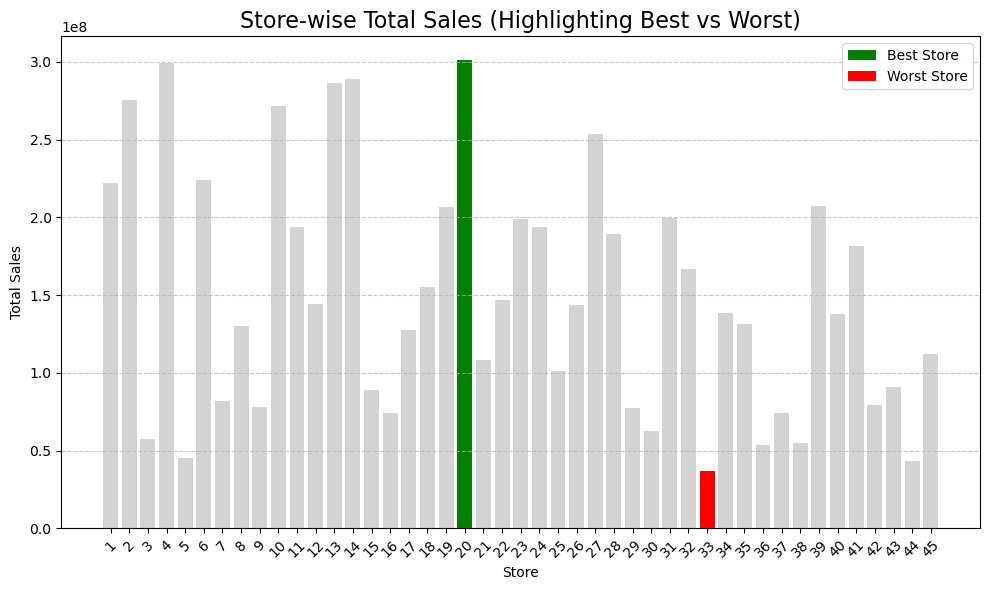

In [16]:
# Find best and worst performing stores
best_store = store_performance.loc[store_performance['Total_Sales'].idxmax()]
worst_store = store_performance.loc[store_performance['Total_Sales'].idxmin()]

# Calculate difference
sales_diff = best_store['Total_Sales'] - worst_store['Total_Sales']
percent_diff = (sales_diff / best_store['Total_Sales']) * 100

print("🏆 Best Performing Store:")
print(best_store)

print("\n❌ Worst Performing Store:")
print(worst_store)

print(f"\n🔎 Difference in Total Sales: {sales_diff:,.2f}")
print(f"📉 Percentage Gap between Best and Worst: {percent_diff:.2f}%")

# --- Visualization ---
plt.figure(figsize=(10,6))
plt.bar(store_performance['Store'].astype(str), store_performance['Total_Sales'], color='lightgray')
plt.bar(str(int(best_store['Store'])), best_store['Total_Sales'], color='green', label='Best Store')
plt.bar(str(int(worst_store['Store'])), worst_store['Total_Sales'], color='red', label='Worst Store')

plt.title("Store-wise Total Sales (Highlighting Best vs Worst)", fontsize=16)
plt.xlabel("Store")
plt.ylabel("Total Sales")
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## 2. Use predictive modeling techniques to forecast the sales for each store for the next 12 weeks 

In [17]:
#Forecast Function using SARIMA
def forecast_sales_sarima(store_id):
    # Filter store data
    store_df = df[df['Store'] == store_id][['Date', 'Weekly_Sales']].copy()
    store_df['Date'] = pd.to_datetime(store_df['Date'], errors='coerce')
    store_df.set_index('Date', inplace=True)

    # Make sure weekly frequency is set
    store_df = store_df.asfreq('W', method='pad')

    # Fit SARIMA model (seasonality ~ yearly = 52 weeks)
    model = SARIMAX(store_df['Weekly_Sales'], 
                    order=(1,1,1), 
                    seasonal_order=(1,1,1,52),
                    enforce_stationarity=False, 
                    enforce_invertibility=False)
    results = model.fit(disp=False)

    # Forecast next 12 weeks
    forecast = results.get_forecast(steps=12)
    forecast_index = pd.date_range(store_df.index[-1] + pd.Timedelta(weeks=1), periods=12, freq='W')

    # Plot historical + forecast
    plt.figure(figsize=(12,6))
    plt.plot(store_df.index, store_df['Weekly_Sales'], label="Historical", color='blue')
    plt.plot(forecast_index, forecast.predicted_mean, label="Forecast", color='orange')
    plt.fill_between(forecast_index,
                     forecast.conf_int().iloc[:,0],
                     forecast.conf_int().iloc[:,1],
                     color='orange', alpha=0.3, label="Confidence Interval")
    plt.title(f"📈 Store {store_id} - 12 Week Sales Forecast (SARIMA)")
    plt.xlabel("Date")
    plt.ylabel("Weekly Sales")
    plt.legend()
    plt.grid(True)
    plt.show()

#Dropdown for store selection
store_ids = sorted(df['Store'].unique())
interact(forecast_sales_sarima, store_id=widgets.Dropdown(options=store_ids, description="Select Store:"))

interactive(children=(Dropdown(description='Select Store:', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13…

<function __main__.forecast_sales_sarima(store_id)>

# ---------Thank You---------